In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms

import lightning as pl

import warnings
warnings.filterwarnings("ignore")

In [38]:
from lightly.transforms import MAETransform

transform = transforms.Compose([transforms.Grayscale(3), MAETransform(input_size=28)])

# we ignore object detection annotations by setting target_transform to return 0
train_dataset = MNIST(
    "data",
    download=True,
    transform=transform,
    train=True
)

test_dataset = MNIST(
    "data",
    download=True,
    transform=transform,
    train=False
)

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [37]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.models import utils
from lightly.models.modules import masked_autoencoder
from lightly.transforms.mae_transform import MAETransform


class MAE(pl.LightningModule):
    def __init__(self):
        super().__init__()

        decoder_dim = 512
        vit = torchvision.models.VisionTransformer(image_size=28, patch_size=4, num_layers=4, num_heads=8, hidden_dim=512, mlp_dim=1024)
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_size
        self.sequence_length = vit.seq_length
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        self.backbone = masked_autoencoder.MAEBackbone.from_vit(vit)
        self.decoder = masked_autoencoder.MAEDecoder(
            seq_length=vit.seq_length,
            num_layers=4,
            num_heads=8,
            embed_input_dim=vit.hidden_dim,
            hidden_dim=decoder_dim,
            mlp_dim=decoder_dim * 4,
            out_dim=vit.patch_size**2 * 3,
            dropout=0,
            attention_dropout=0,
        )
        self.criterion = nn.MSELoss()

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images, idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode.type_as(x_masked))

        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def training_step(self, batch, batch_idx):
        views = batch[0]
        images = views[0]  # views contains only a single view
        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images, idx_keep)
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)

        # get image patches for masked tokens
        patches = utils.patchify(images, self.patch_size)
        # must adjust idx_mask for missing class token
        target = utils.get_at_index(patches, idx_mask - 1)

        loss = self.criterion(x_pred, target)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=1.5e-4)
        return optim


model = MAE()

accelerator = "gpu" if torch.cuda.is_available() else "mps"

trainer = pl.Trainer(max_epochs=10, devices=1, accelerator=accelerator)
trainer.fit(model=model, train_dataloaders=trainloader)
torch.save(model.state_dict(), "mae_weights.pt")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type        | Params
------------------------------------------
0 | backbone  | MAEBackbone | 9.0 M 
1 | decoder   | MAEDecoder  | 12.9 M
2 | criterion | MSELoss     | 0     
------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.601    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [25]:
device = torch.device("mps")

In [27]:
device = torch.device("mps")
model.to(device)
model.eval()
X_embedded, y_true = [], []
with torch.no_grad():
    for (x, y) in tqdm(trainloader):
        x, y = x[0].to(device), y.to(device)
        embeddings = model.backbone(x)
        X_embedded.append(embeddings.detach().cpu().numpy())
        y_true.append(y.detach().cpu().numpy())
        
X_embedded, y_true = np.concatenate(X_embedded), np.concatenate(y_true)

100%|██████████| 937/937 [00:40<00:00, 22.87it/s]


<Axes: >

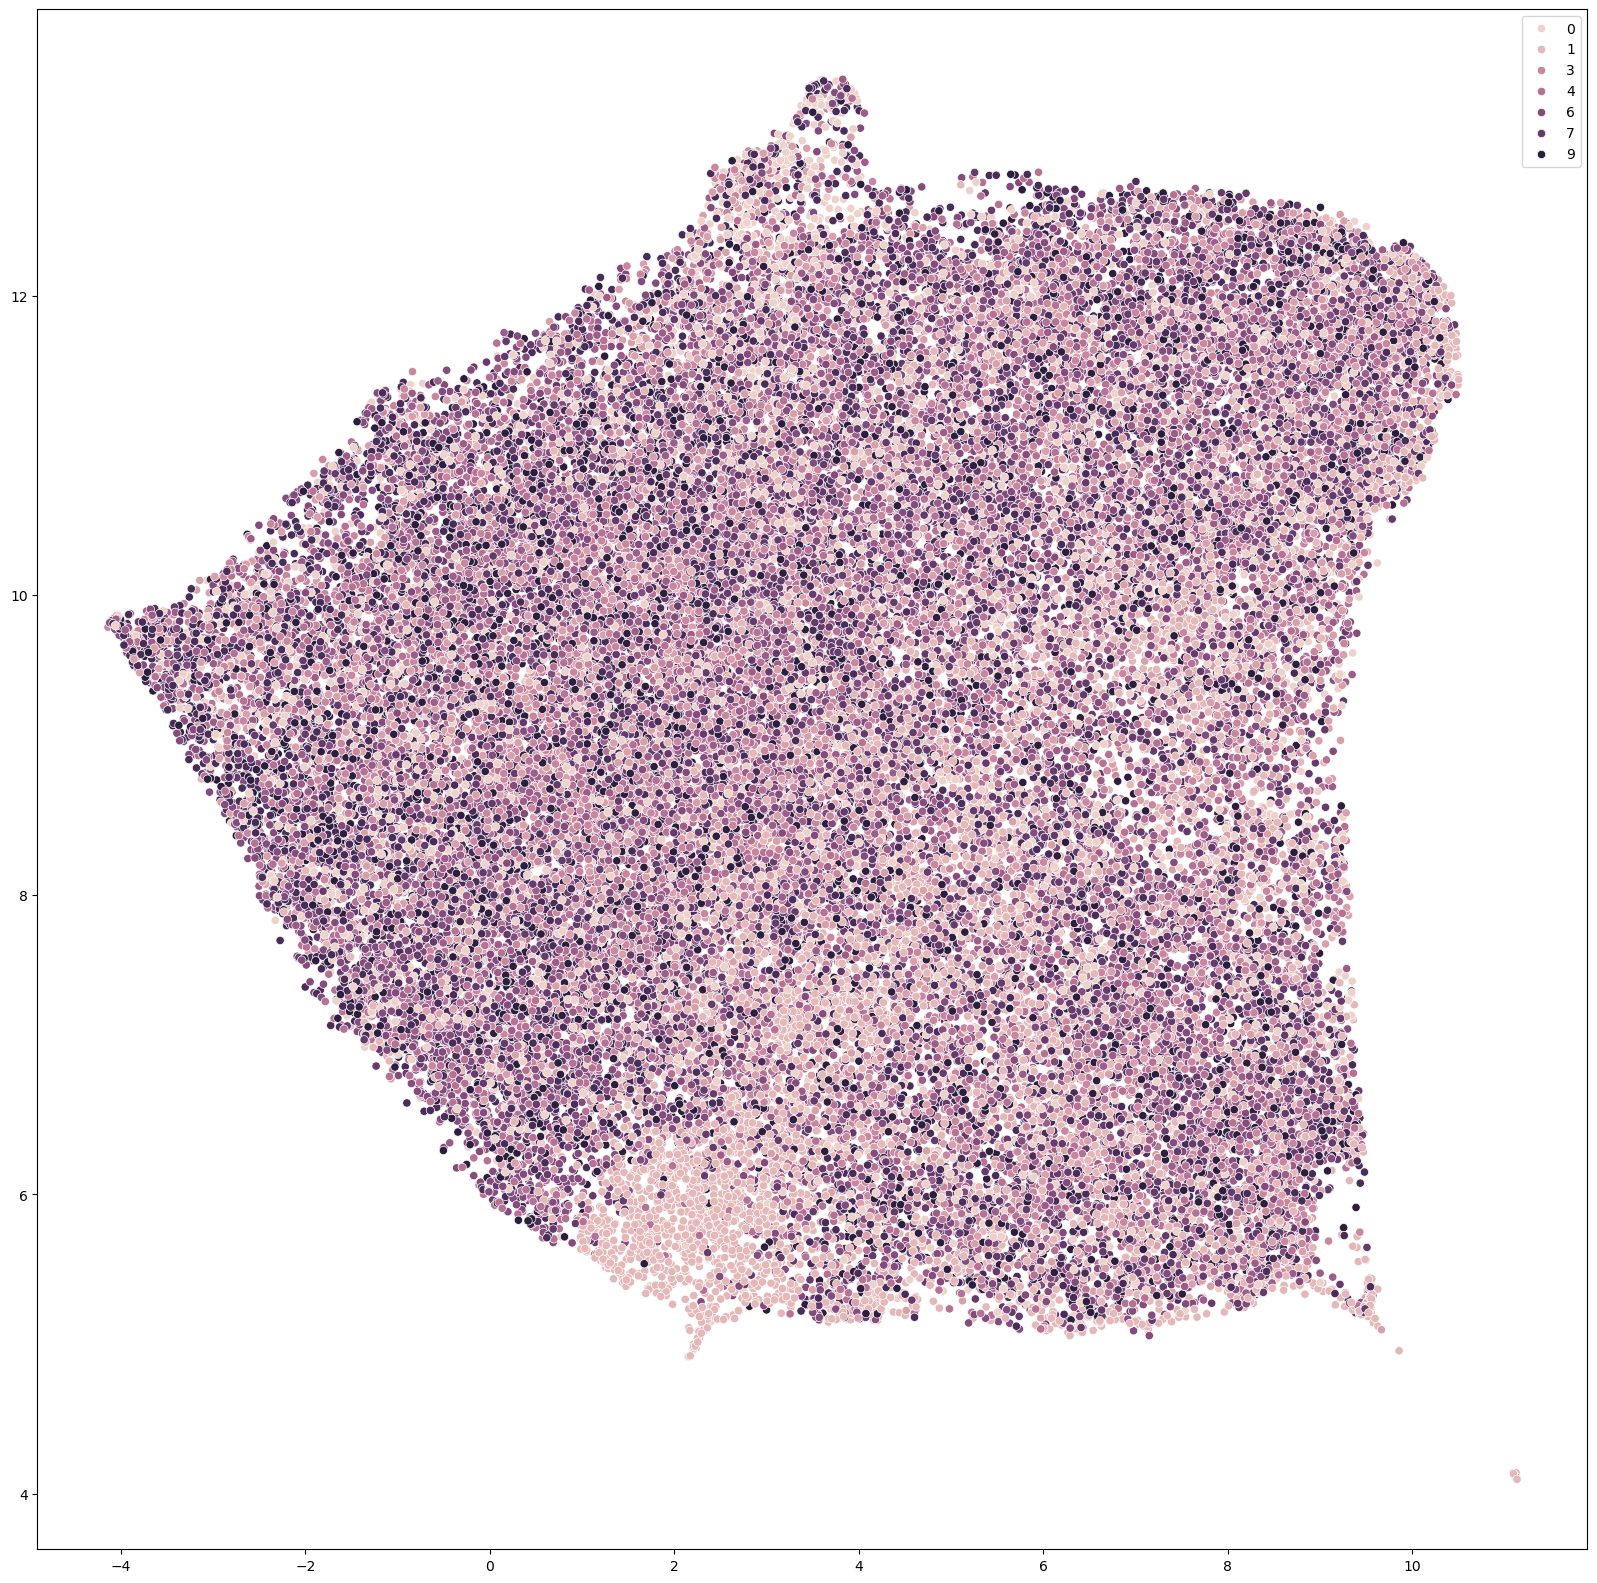

In [36]:
import umap

mapper = umap.UMAP(n_components=2)
manifold = mapper.fit_transform(X_embedded)

fig, ax = plt.subplots(1,1,figsize=(20,20))
sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=y_true, ax=ax)